In [33]:
% matplotlib inline

In [34]:
% config InlineBackend.figure_format = 'retina'

In [35]:
import numpy as np
import scipy
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import pickle
from tqdm import tqdm
from utils import anisotropic_kernel, get_taluk_df

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

Code follows below.

In [38]:
np.random.seed(123)

In [39]:
fold_idx = 21

In [40]:
elec_data = pd.read_csv("../data/electrification.csv")

In [41]:
pearsonr(elec_data["daily_exp"], elec_data["electrification"])

(0.24690479704323848, 0.0)

In [42]:
df = pd.read_csv("../results/fold_%d/test_results.csv" % fold_idx)

In [43]:
print(df["state_name"][0])

Rajasthan


In [44]:
print("Length of original test set: %d" % len(df))

Length of original test set: 41477


In [45]:
df = df.merge(elec_data, how="inner", left_on="id", right_on="village_id")

In [46]:
df = df.loc[:,("smoothed", "true", "lat", "lng", "taluk_idx", "district_idx", "electrification", "pop")]
df = df.rename(columns={"smoothed": "pred"})

In [47]:
print("Length of merged test set: %d" % len(df))

Length of merged test set: 35293


In [48]:
print("Shape:", df.shape)

Shape: (35293, 8)


In [49]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

Text(0.5,1,'Predicted Expenditure')

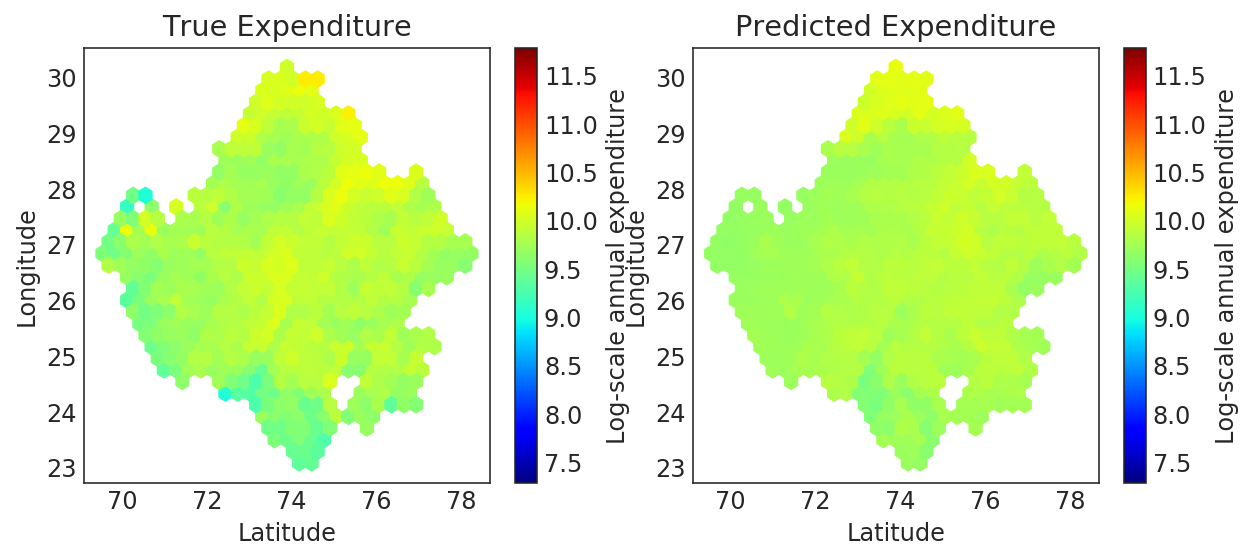

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], C=df["pred"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Expenditure")

In [51]:
scipy.stats.pearsonr(df["pred"], df["true"])

(0.526988552550905, 0.0)

In [52]:
logit = sm.Logit(df['electrification'], df["true"])

In [53]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.682354
         Iterations 4


In [54]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        electrification   No. Observations:                35293
Model:                          Logit   Df Residuals:                    35292
Method:                           MLE   Df Model:                            0
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:              -0.0005129
Time:                        03:02:38   Log-Likelihood:                -24082.
converged:                       True   LL-Null:                       -24070.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
true          -0.0300      0.001    -27.452      0.000      -0.032      -0.028
==============================================================================
"""

Aggregate to the taluk level for computational efficiency -- there are 651 taluks.

In [55]:
taluk_df = get_taluk_df(df)

In [56]:
print("Shape", taluk_df.shape)

Shape (215, 6)


In [57]:

true_beta = pearsonr(taluk_df["electrification"], taluk_df["true"])[0]
print(true_beta)

0.4088893910186583


In [58]:
lm = sm.OLS(taluk_df["electrification"], taluk_df["true"])
result = lm.fit()

In [59]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        electrification   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     2038.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          2.39e-111
Time:                        03:02:43   Log-Likelihood:                 55.061
No. Observations:                 215   AIC:                            -108.1
Df Residuals:                     214   BIC:                            -104.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
true           0.0587      0.001     45.149      0.000       0.056       0.061
==============================================================================
Omnibus:                        4.133   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                4.143
Skew:                          -0.337   Prob(JB):                        0.126
Kurtosis:                       2.908   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
df = taluk_df

#### Sampling

In [61]:
idxs = np.arange(len(df))
train_idxs = np.random.choice(idxs, int(0.5 * len(idxs)), replace=False)
val_idxs = np.array(list(set(idxs) - set(train_idxs)))

In [62]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [63]:
len(df_train), len(df_val)

(107, 108)

Text(0,0.5,'Latitude')

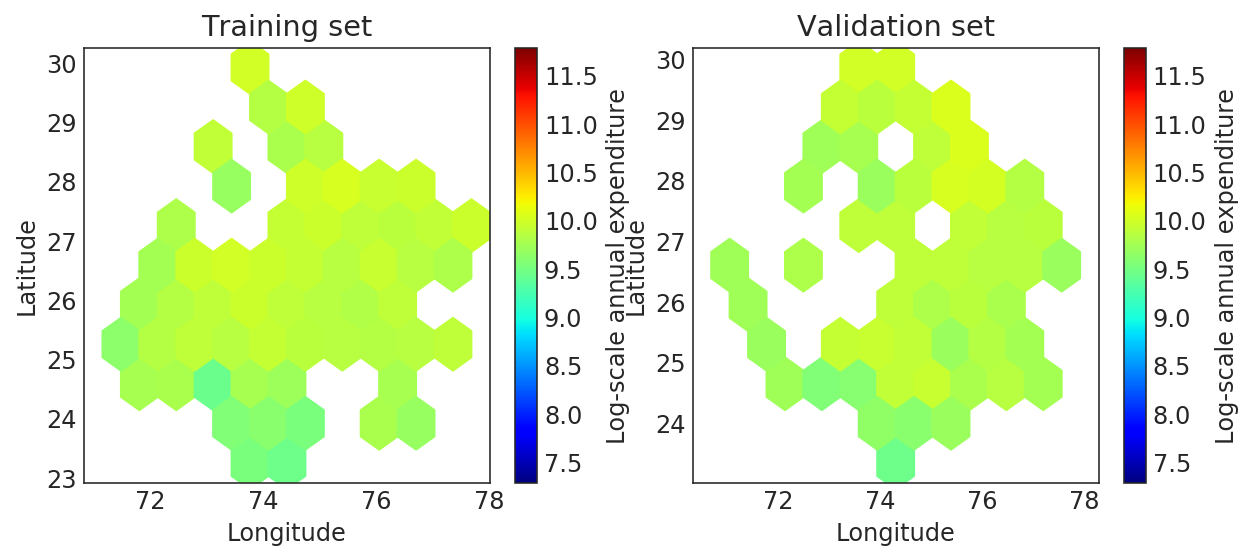

In [64]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_train["lng"], df_train["lat"], gridsize=10, C=df_train["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Training set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=10, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Validation set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### Coefficient Estimation

In [65]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from utils import SubspaceRBF

In [66]:
class SubspaceDot(DotProduct):
  """
  Modification of the DotProduct kernel to only act on specified dimensions.
  i.e. K(x, y) = sigma^2 x[dims] ^\top y[dims]
  """
  def __init__(self, dims, sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5)):
    super(SubspaceDot, self).__init__(sigma_0, sigma_0_bounds)
    self.dims = dims

  def __call__(self, X, Y=None, eval_gradient=False):
    if Y is None:
      return super(SubspaceDot, self).__call__(
        X[:,self.dims], None, eval_gradient=eval_gradient)
    else:
      return super(SubspaceDot, self).__call__(
        X[:,self.dims], Y[:,self.dims], eval_gradient=eval_gradient)


In [67]:
anisotropic_kernel = ConstantKernel() * SubspaceRBF(dims=np.array([0, 1])) + \
                     ConstantKernel() * SubspaceRBF(dims=np.array([2]))

In [89]:
anisotropic_kernel = ConstantKernel() + \
                     SubspaceRBF(dims=np.array([0, 1]), length_scale=1.0,
                                 length_scale_bounds=(1e-3, 1e3)) + \
                     SubspaceRBF(dims=np.array([2]))

In [166]:
idxs = [0]
sampled_betas = []
sampled_betas_all = []

In [167]:
from tqdm import tqdm

In [169]:
for _ in tqdm(range(1, 200)):
  df_sampled = df.iloc[df.index.isin(idxs),:]
  df_rest = df.iloc[~df.index.isin(idxs),:]
  
  sampled_betas.append(pearsonr(df_sampled["electrification"], df_sampled["true"])[0])
  gp = GaussianProcessRegressor(kernel=anisotropic_kernel, normalize_y=True)
  gp.fit(df_sampled.loc[:,("lat", "lng", "pred", "electrification")], df_sampled["true"])
  preds = gp.sample_y(df_rest.loc[:, ("lat", "lng", "pred", "electrification")], n_samples = 10)
  idx = df_rest.index[np.argmax(np.std(preds, axis=1))]
  idxs.append(idx)
  
  elec = np.r_[df_sampled["electrification"], df_rest["electrification"]]
  cons = np.r_[df_sampled["true"], df_rest["pred"] + gp.predict(df_rest.loc[:, ("lat", "lng", "pred", "electrification")])]
  sampled_betas_all.append(
    pearsonr(elec, cons)[0]
  )

100%|██████████| 199/199 [00:34<00:00,  5.77it/s]


In [170]:
np.mean(df_sampled["electrification"]), np.std(df_sampled["electrification"])

(0.5773430197352772, 0.19283870969802455)

In [171]:
np.mean(df["electrification"]), np.std(df["electrification"])

(0.5770092298086682, 0.19055428778511252)

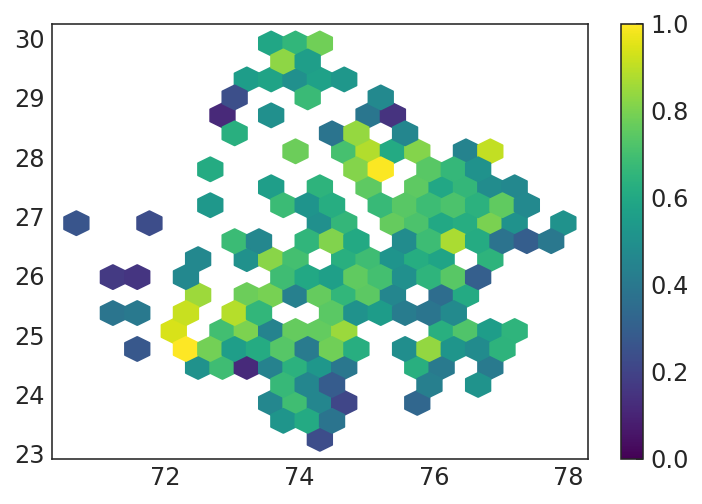

In [172]:
hb = plt.hexbin(df_sampled["lng"], df_sampled["lat"], gridsize=20, 
                C=df_sampled["electrification"], cmap=cm.viridis, vmax=1, vmin=0)
plt.colorbar()

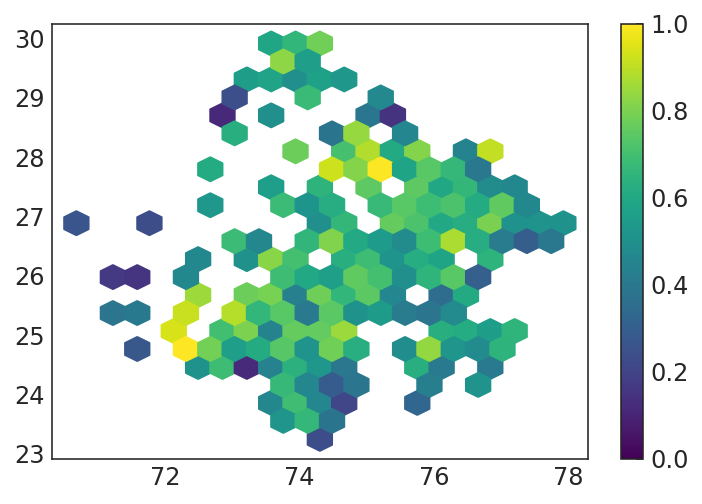

In [173]:
hb = plt.hexbin(df["lng"], df["lat"], gridsize=20, C=df["electrification"], cmap=cm.viridis, vmax=0, vmin=1)
plt.colorbar()

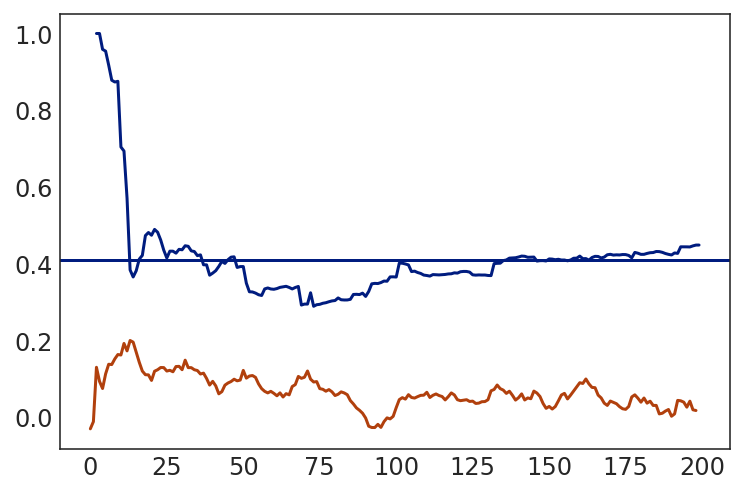

In [174]:
plt.plot(sampled_betas)
plt.plot(sampled_betas_all)
plt.axhline(true_beta)

#### 1(a). Oracle: regress using (lat, lng) with all data points

In [107]:
gbm = GradientBoostingRegressor(n_estimators=300)
gbm.fit(df_train.loc[:,("lat", "lng")], df_train["true"]);

In [108]:
"R2 all training pts, loc only: %.3f" % r2_score(df_val["true"], gbm.predict(df_val.loc[:,("lat", "lng")]))

'R2 all training pts, loc only: 0.295'

#### 1(b). Oracle: using (lat, lng, pred) with all data points

In [109]:
gp = GradientBoostingRegressor()
gp.fit(df_train.loc[:,("lat", "lng", "pred")], df_train["true"])
mean = gp.predict(df_val.loc[:,("lat", "lng", "pred")])

In [110]:
print("R2 all training pts: %.3f" % r2_score(df_val["true"], mean))

R2 all training pts: 0.531


In [111]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale_bounds=(1e-3, 1000))

In [112]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [113]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_train.loc[:,("lat", "lng")], df_train["true"] - df_train["pred"])
preds = gp.predict(df_val.loc[:, ("lat", "lng")]) + df_val["pred"]

In [114]:
print("R2 all training pts, GP: %.3f" % r2_score(df_val["true"], preds))

R2 all training pts, GP: 0.711


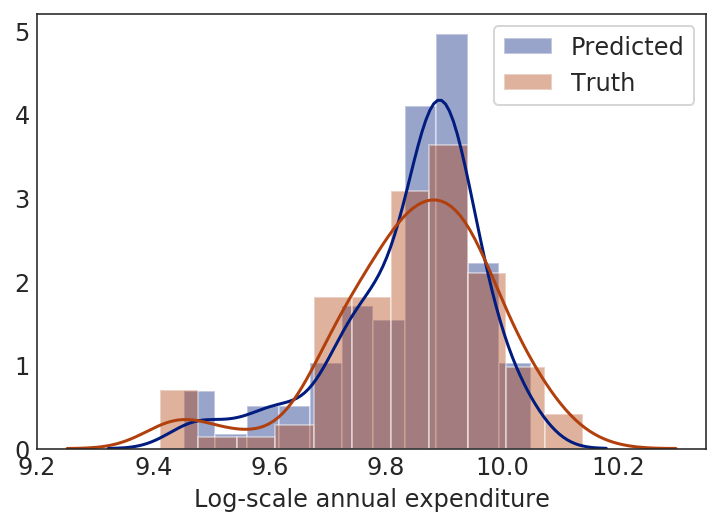

In [115]:
sns.distplot(preds, label="Predicted")
sns.distplot(df_val["true"], label="Truth")
plt.xlabel("Log-scale annual expenditure")
plt.legend()

Text(0.5,0,'Longitude')

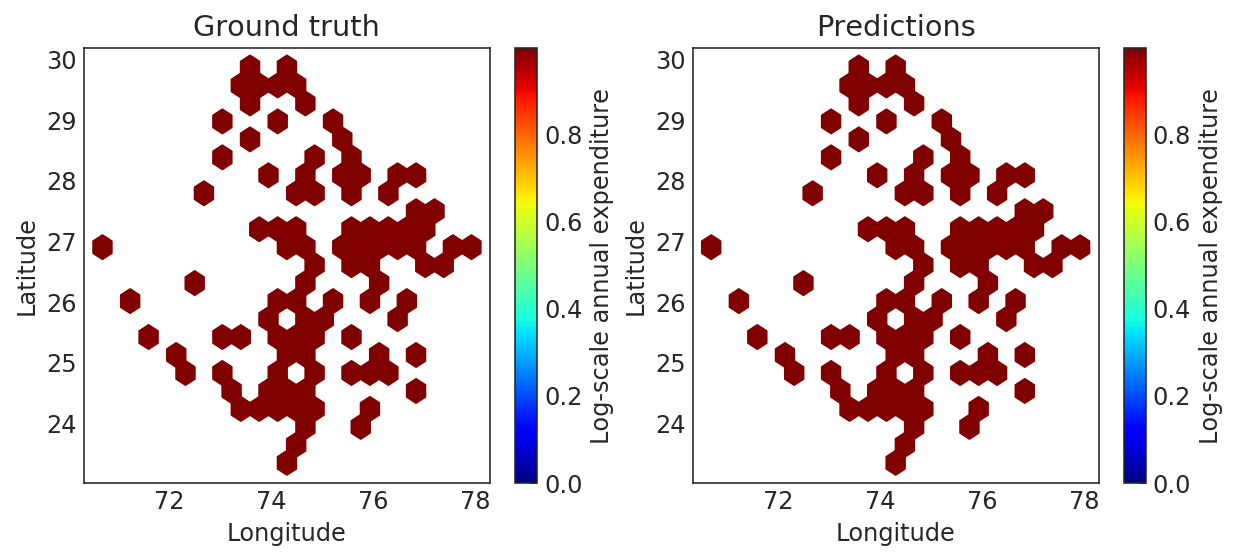

In [122]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Ground truth")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=preds, cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Predictions")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")

#### 2. Baseline: regress using satellite preds only with all data points

In [117]:
lm = LinearRegression()
lm.fit(df_train.loc[:,("pred")].values.reshape(-1,1), df_train["true"]);

In [118]:
print("R2 satellite only: %.3f" % r2_score(df_val["true"], df_val["pred"]))
print("R2 satellite only, LM: %.3f" % r2_score(df_val["true"], lm.predict(df_val.loc[:,("pred")].values.reshape(-1,1))))

R2 satellite only: 0.594
R2 satellite only, LM: 0.587


#### 3. Comparison: randomly pick 20 points and use (satellite data + lat + lng)

In [119]:
bootstrap_r2s = []
for i in tqdm(range(100)):
  sampled_idxs = np.random.choice(np.arange(len(df_train)), 20, replace=False)
  df_sampled = df_train.iloc[sampled_idxs]
  gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
  gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
  r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")]))
  bootstrap_r2s.append(r2)

100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


In [120]:
"R2 20 random samples -- 95%% CI: [%.3f %.3f]" % tuple(np.percentile(bootstrap_r2s, (2.5, 97.5)))

'R2 20 random samples -- 95% CI: [-0.046 0.706]'

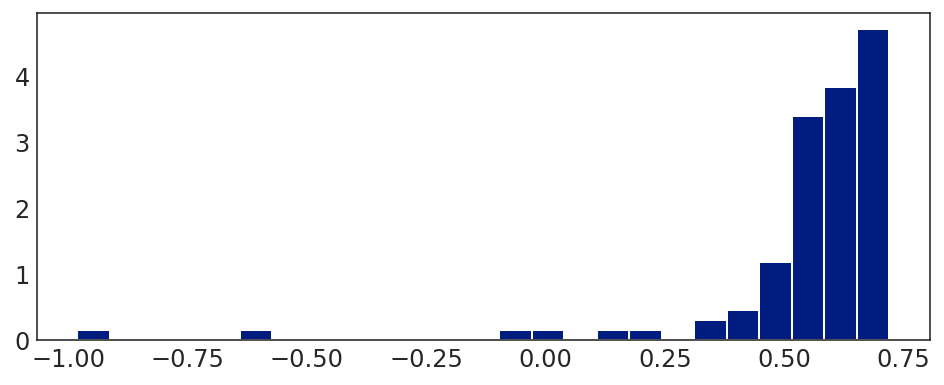

In [121]:
plt.figure(figsize=(8, 3))
plt.hist(bootstrap_r2s, bins=25, density=True);

#### 4. GP: greedily pick 20 points and use (satellite data + lat + lng)

In [284]:
def greedy_selection(init_kernel, n_samples, X, y, chol_inv=True):
  
  remaining_indices = set(np.arange(len(X)))
  picked_indices = set()

  first_pick = np.random.randint(0, len(X))
  picked_indices.add(first_pick)
  remaining_indices.remove(first_pick)

  greedy_order = [first_pick]
  
  for i in tqdm(range(n_samples - 1)):

    gp = GaussianProcessRegressor(kernel=init_kernel, normalize_y=True)
    
    # Fit the GP with the points we've sampled so far
    # this does likelihood maximization to find kernel hyperparameters 
    # in addition to doing GP regression
    gp.fit(X[np.array(sorted(list(picked_indices)))], y[np.array(sorted(list(picked_indices)))])
    
    # This is kernel with ML estimates for hyperparams
    kernel = gp.kernel_
    
    # Compute the variance at the points that are available to sample
    var_y = np.diag(kernel(X[np.array(sorted(list(remaining_indices))),:]))

    # Find the covariance matrix for the sampled points and invert
    cov_AA = kernel(X[np.array(sorted(list(picked_indices)))])
    if chol_inv:
      chol = cholesky(cov_AA)
      inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
      inv_cov_AA = np.dot(inv_chol,np.transpose(inv_chol))
    else:
      inv_cov_AA = np.linalg.inv(cov_AA)

    # Find the kernel matrix of the picked points wrt remaining points
    cov_Ay = kernel(X[np.array(sorted(list(picked_indices)))], X[np.array(sorted(list(remaining_indices)))])
    cov_yA = np.transpose(cov_Ay)

    # Run the selection procedure over the remaining indices 
    # (note it is possible to speed this up: there is a section in the 
    # paper on speeding up this process for large numbers of points)
    max_delta_j, greedy_idx = float("-inf"), -1
    
    for idx, j in enumerate(sorted(list(remaining_indices))):
      
      cov_AbarAbar = kernel(X[np.array(sorted(list(remaining_indices - set([j])))),:])
      if chol_inv:
        chol = np.linalg.cholesky(cov_AbarAbar)
        inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
        inv_cov_AbarAbar = np.dot(inv_chol,np.transpose(inv_chol))
      else:
        inv_cov_AbarAbar = np.linalg.inv(cov_AbarAbar)

      cov_Abary = kernel(X[np.array(sorted(list(remaining_indices - set([j]))))], X[j,:][np.newaxis,:])
      cov_yAbar = np.transpose(cov_Abary)
      delta_j = (var_y[idx] - np.dot(np.dot(cov_yA[idx,:][np.newaxis,:],inv_cov_AA),
                                     cov_Ay[:,idx][:,np.newaxis]))/(var_y[idx] - np.dot(np.dot(cov_yAbar,inv_cov_AbarAbar),cov_Abary))
      delta_j = delta_j.flatten()[0]

      if delta_j > max_delta_j:
        max_delta_j = delta_j
        greedy_idx = j

    picked_indices.add(greedy_idx)
    remaining_indices.remove(greedy_idx)
    greedy_order.append(greedy_idx)
    
  return greedy_order

In [285]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000))

In [301]:
anisotropic_kernel = WhiteKernel() + \
                     ConstantKernel() * \
                     RBF(length_scale=(1.0, 1.0, 1.0), length_scale_bounds=(1e-3, 1000)) + \
                     RBF(length_scale=(1.0, 1.0, 1.0), length_scale_bounds=(1e-3, 1000))

Experiments to test out functionality below...

In [302]:
idxs = greedy_selection(
  anisotropic_kernel, 20,
  df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:07<00:00,  2.66it/s]


In [288]:
idxs_nosat = greedy_selection(
  kernel, 20, 
  df_train.loc[:,("lat", "lng")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


In [289]:
df_sampled = df_train.iloc[np.array(idxs[:8]),:]

In [290]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [291]:
mean, std = gp.predict(df_val.loc[:,("lat", "lng",)], return_std=True)

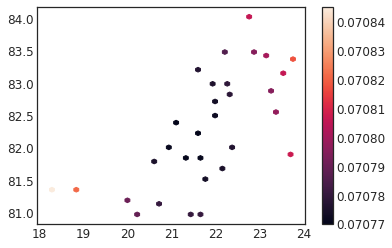

In [292]:
plt.figure(figsize=(6,4))
plt.hexbin(df_val["lat"], df_val["lng"], C=std, gridsize=50)
cb = plt.colorbar()

Text(0.5,1,'Train set')

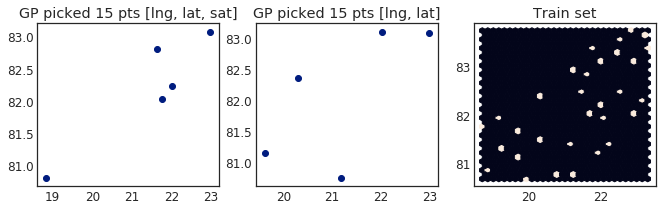

In [295]:
plt.figure(figsize=(15, 3))
plt.subplot(1,4,1)
df_sampled = df_train.iloc[idxs[:5],:]
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat, sat]")
plt.subplot(1,4,2)
df_sampled = df_train.iloc[idxs_nosat[:5],:]
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat]")
plt.subplot(1,4,3)
plt.hexbin(df_train["lat"], df_train["lng"], gridsize=30)
plt.title("Train set")

In [589]:
class SamplingLogger(object):
  
  def __init__(self, name):
    self.name = name
    self.r2s_matrix = []
    self.mses_matrix = []
    self.coeffs_matrix = []
    self.r2s = []
    self.mses = []
    self.coeffs = []

  def tick(self, df_sampled, df_val, preds):
    self.r2s.append(r2_score(df_val["true"], preds))
    self.mses.append(mean_squared_error(df_val["true"], preds))
    preds = np.r_[preds, df_sampled["true"]]
    elec = np.r_[df_val["electrification"], df_sampled["electrification"]]
    self.coeffs.append(np.polyfit(preds, elec, deg=1)[0])
    
  def clear_run(self):
    if self.r2s:
      self.r2s_matrix.append(self.r2s)
    if self.mses:
      self.mses_matrix.append(self.mses)
    if self.coeffs:
      self.coeffs_matrix.append(self.coeffs)
    self.r2s = []
    self.mses = []
    self.coeffs = []
    
  def save(self, fold_idx):
    pickle.dump(self, open("../results/fold_%d/sampling_%s.pkl" % (fold_idx, self.name), "wb"))

In [597]:
def sample_greedy_with_sat(df_train, df_val, n_reps=3):
  """
  Sample greedily, building on top of satellite predictions.
  """
  logger = SamplingLogger("greedy_sat")
  for _ in range(n_reps):
    idxs = greedy_selection(
      anisotropic_kernel, len(df_train) - 1, 
      df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
      np.array(df_train["true"] - df_train["pred"]), chol_inv=False)
    for i in tqdm(range(1, len(idxs) + 1)):
      df_sampled = df_train.iloc[idxs[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")]) + df_val["pred"]
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [598]:
def sample_greedy_no_sat(df_train, df_val, n_reps=3):
  """
  Sample greedily, without building on satellite predictions.
  """
  logger = SamplingLogger("greedy_nosat")
  for _ in range(n_reps):
    idxs = greedy_selection(
      kernel, len(df_train) - 1, 
      df_train.loc[:,("lat", "lng")].as_matrix(),
      np.array(df_train["true"]), chol_inv=False)
    for i in tqdm(range(1, len(idxs) + 1)):
      df_sampled = df_train.iloc[idxs[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [599]:
def sample_random_with_sat(df_train, df_val, n_reps=5):
  """
  Randomly sample, building on top of satellite predictions.
  """
  logger = SamplingLogger("random_sat")
  for _ in range(n_reps):
    idxs_random = np.arange(len(df_train))
    np.random.shuffle(idxs_random)
    for i in tqdm(range(1, len(df_train))):
      df_sampled = df_train.iloc[idxs_random[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
      preds = df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [600]:
def sample_random_no_sat(df_train, df_val, n_reps=5):
  """
  Randomly sample, without building on top of satellite predictions.
  """
  logger = SamplingLogger("random_nosat")
  for _ in range(n_reps):
    idxs_random = np.arange(len(df_train))
    np.random.shuffle(idxs_random)
    for i in tqdm(range(1, len(df_train))):
      df_sampled = df_train.iloc[idxs_random[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
  return logger

In [590]:
logs = sample_random_with_sat(df_train, df_val)

100%|██████████| 29/29 [00:03<00:00,  8.64it/s]


In [592]:
logs.save(4)

In [342]:
new, _ = sample_random_with_sat(df_train, df_val)

100%|██████████| 30/30 [00:03<00:00,  9.28it/s]


In [ ]:
pd.to_csv("../results/fold_%d/sampling_train.csv" % fold_idx, df_train)
pd.to_csv("../results/fold_%d/sampling_val.csv" % fold_idx, df_val)

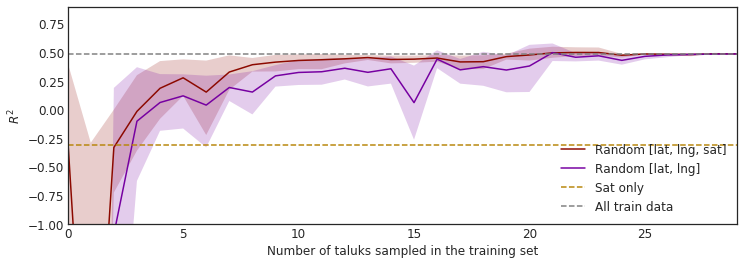

In [343]:
plt.figure(figsize=(12, 4))
sns.tsplot(a, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
sns.tsplot(c, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(new, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(bkup, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df_val["true"], df_val["pred"]), ls="--", color=plt_colors[4], label="Sat only")
plt.axhline(r2_score(df_val["true"], preds), ls="--", color="grey", label="All train data")
plt.ylim(-1, 0.9)
plt.legend();

In [262]:
np.polyfit(df_val["true"], df_val["electrif
                                  ication"], deg=1)

array([ 0.15495135, -1.09388836])

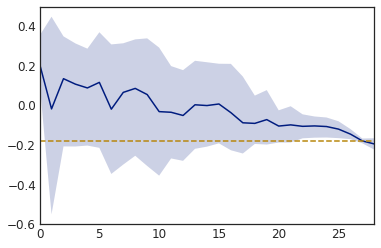

In [606]:
sns.tsplot(logs.coeffs_matrix, ci=95)
plt.axhline(-0.18290039, ls="--", color=plt_colors[4], label="Sat only")